# 🧠 Multi-Layer Perceptron (MLP) – Facies Classification

**MLP** is a type of feedforward neural network. It learns a mapping from input features (well-logs) to output classes (facies).  
It consists of an **input layer**, one or more **hidden layers**, and an **output layer**.  

---

## 🔹 1. Neuron Model
Each neuron takes weighted inputs, adds a bias, and applies an activation function:

$$
z^{(l)}_j = \sum_i w^{(l)}_{ji} a^{(l-1)}_i + b^{(l)}_j, \quad 
a^{(l)}_j = f(z^{(l)}_j)
$$

- \( w \): weights (strength of connection)  
- \( b \): bias (shifts the activation)  
- \( f \): activation (non-linearity)  
- \( a \): neuron output  

---

## 🔹 2. Activation Functions
Introduce non-linearity so the network can learn complex relationships:  

- **ReLU:**  \( f(x) = \max(0, x) \) → avoids vanishing gradients  
- **Sigmoid:** \( f(x) = \frac{1}{1+e^{-x}} \) → outputs [0,1]  
- **Tanh:** \( f(x) = \tanh(x) \) → outputs [-1,1]  
- **Softmax (multi-class):**

$$
\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_j e^{z_j}}
$$

---

## 🔹 3. Forward Propagation
Data flows from input → hidden layers → output:

$$
a^{(l)} = f(W^{(l)} a^{(l-1)} + b^{(l)})
$$

---

## 🔹 4. Loss Function
MLP minimizes **Cross-Entropy Loss** for classification:

$$
\mathcal{L} = - \frac{1}{N}\sum_{i=1}^N \sum_{k=1}^K y_{i,k}\,\log(\hat{y}_{i,k})
$$

- \(N\): number of samples  
- \(K\): number of classes (facies types)  
- \(y_{i,k}\): true label (1 if class \(k\), else 0)  
- \(\hat{y}_{i,k}\): predicted probability  

---

## 🔹 5. Backpropagation & Weight Update
Weights are updated using gradient descent:

$$
W \leftarrow W - \eta \frac{\partial \mathcal{L}}{\partial W}, \quad 
b \leftarrow b - \eta \frac{\partial \mathcal{L}}{\partial b}
$$

- \(\eta\): learning rate  

---

## 🔹 6. Training Pipeline
1. Initialize weights randomly  
2. Forward pass → compute activations  
3. Compute loss (Cross-Entropy)  
4. Backward pass (Backpropagation)  
5. Update weights (Gradient Descent / Adam)  
6. Repeat for many epochs until convergence  

---

## 🔹 7. Application to Facies Classification
- **Input:** well-log features (GR, ILD, DT, RHOB, NPHI, PE, etc.)  
- **Hidden layers:** extract nonlinear patterns  
- **Output:** facies type (e.g., sandstone, shale, limestone)  
- **Evaluation:** accuracy, confusion matrix, adjacent facies accuracy  


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler


2025-09-06 12:27:08.225927: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-06 12:27:08.795599: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-06 12:27:16.763823: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
data=pd.read_csv('../../data/final-data.csv')
df=data.copy()

In [3]:
df.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,PHID,NPHI,VSH,Bulk Density,PE_filled
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000,6.965,16.865,0.191740,2.453403,Original
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979,5.465,19.665,0.194048,2.442677,Original
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957,5.650,20.450,0.196299,2.434675,Original
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936,6.165,20.065,0.216384,2.433603,Original
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915,6.550,20.050,0.183564,2.430550,Original


In [4]:
df['Well Name'] = df['Well Name'].astype('category')
df['Formation'] = df['Formation'].astype('category')
df['Well Name'].unique()



['SHRIMPLIN', 'ALEXANDER D', 'SHANKLE', 'LUKE G U', 'KIMZEY A', 'CROSS H CATTLE', 'NOLAN', 'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE']
Categories (10, object): ['ALEXANDER D', 'CHURCHMAN BIBLE', 'CROSS H CATTLE', 'KIMZEY A', ..., 'NOLAN', 'Recruit F9', 'SHANKLE', 'SHRIMPLIN']

In [5]:
# 1=sandstone  2=c_siltstone   3=f_siltstone # 4=marine_silt_shale 
#5=mudstone 6=wackestone 7=dolomite 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041', '#DC7633','#A569BD',
       '#000000', '#000080', '#2E86C1', '#AED6F1', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']

facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
df.loc[:,'FaciesLabels'] = df.apply(lambda row: label_facies(row, facies_labels), axis=1)
df.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,PHID,NPHI,VSH,Bulk Density
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.765204,1.518438,0.521852,10.999824,15.402308,0.156082,2.432182
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.848630,0.499720,0.286644,8.059673,7.121038,0.086332,0.117692
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000,-5.000000,2.090000,0.000000,1.257400
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.200000,1.000000,0.277000,6.259000,10.025000,0.098521,2.385175
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.600000,2.000000,0.528000,8.900000,14.842000,0.156242,2.451670
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000,13.165000,19.385000,0.197404,2.509750
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000,83.500000,85.400000,1.000000,2.640925


## Keep one blind well

In [6]:
blind_well = df[df['Well Name']=='SHRIMPLIN']
training_data = df[df['Well Name']!='SHRIMPLIN']
print(f"These are the well after keep a blind well:\n ",training_data['Well Name'].unique())


These are the well after keep a blind well:
  ['ALEXANDER D', 'SHANKLE', 'LUKE G U', 'KIMZEY A', 'CROSS H CATTLE', 'NOLAN', 'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE']
Categories (10, object): ['ALEXANDER D', 'CHURCHMAN BIBLE', 'CROSS H CATTLE', 'KIMZEY A', ..., 'NOLAN', 'Recruit F9', 'SHANKLE', 'SHRIMPLIN']


In [7]:
#I changed the colors to match the paper for easier compare.
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)
    return f, ax
    

In [8]:
df["Well Name"].unique()

['SHRIMPLIN', 'ALEXANDER D', 'SHANKLE', 'LUKE G U', 'KIMZEY A', 'CROSS H CATTLE', 'NOLAN', 'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE']
Categories (10, object): ['ALEXANDER D', 'CHURCHMAN BIBLE', 'CROSS H CATTLE', 'KIMZEY A', ..., 'NOLAN', 'Recruit F9', 'SHANKLE', 'SHRIMPLIN']

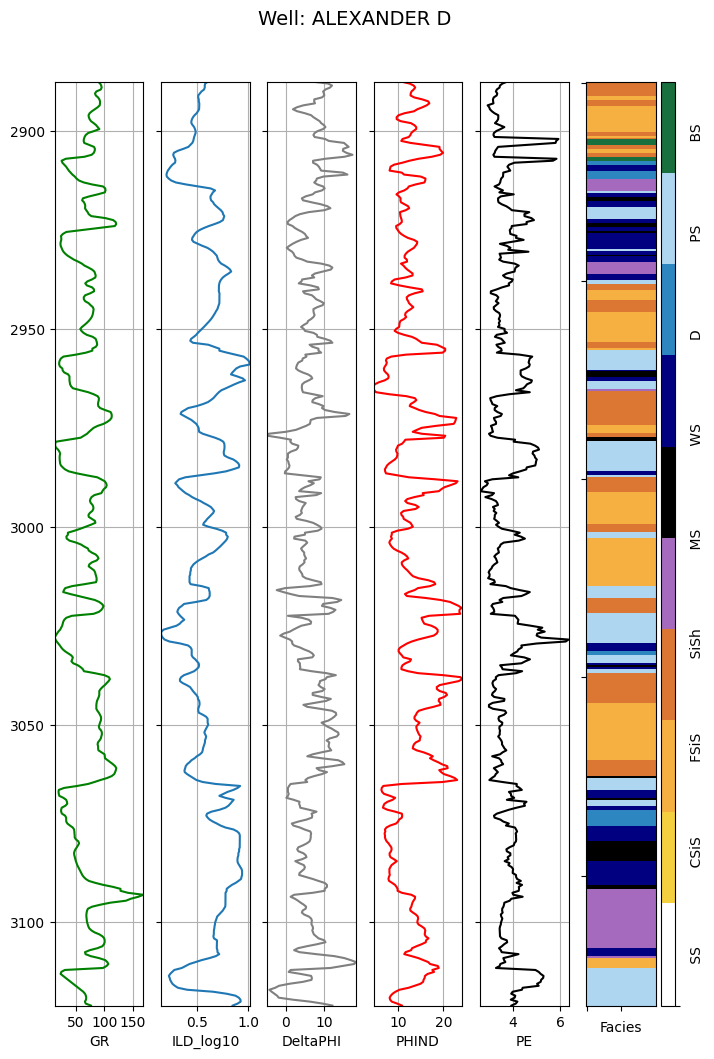

In [9]:
make_facies_log_plot(df[df['Well Name']=='ALEXANDER D'], facies_colors)
plt.savefig('../../figures/supervised/MLP-training_data_example_log_plot.png', dpi=300)

## Data conditioning

In [10]:
actual_facies = df['Facies'].values
actual_facies

array([3, 3, 3, ..., 5, 5, 5], shape=(4149,))

In [11]:
print(df['Facies'].value_counts())

Facies
2    940
3    780
8    686
6    582
5    296
4    271
1    268
9    185
7    141
Name: count, dtype: int64


In [12]:
print(df.isnull().sum())

Facies          0
Formation       0
Well Name       0
Depth           0
GR              0
ILD_log10       0
DeltaPHI        0
PHIND           0
PE              0
NM_M            0
RELPOS          0
PHID            0
NPHI            0
VSH             0
Bulk Density    0
PE_filled       0
FaciesLabels    0
dtype: int64


## Feature and targets

In [13]:
df.columns

Index(['Facies', 'Formation', 'Well Name', 'Depth', 'GR', 'ILD_log10',
       'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS', 'PHID', 'NPHI', 'VSH',
       'Bulk Density', 'PE_filled', 'FaciesLabels'],
      dtype='object')

In [14]:
features=df.drop(columns=['Well Name', 'Formation', 'Depth', 'Facies', 'FaciesLabels'])
targets=df['Facies']

In [15]:
features.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,PHID,NPHI,VSH,Bulk Density
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000
mean,64.933985,0.659566,4.402484,13.201066,3.765204,1.518438,0.521852,10.999824,15.402308,0.156082,2.432182
std,30.302530,0.252703,5.274947,7.132846,0.848630,0.499720,0.286644,8.059673,7.121038,0.086332,0.117692
min,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000,-5.000000,2.090000,0.000000,1.257400
25%,44.730000,0.498000,1.600000,8.500000,3.200000,1.000000,0.277000,6.259000,10.025000,0.098521,2.385175
50%,64.990000,0.639000,4.300000,12.020000,3.600000,2.000000,0.528000,8.900000,14.842000,0.156242,2.451670
75%,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000,13.165000,19.385000,0.197404,2.509750
max,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000,83.500000,85.400000,1.000000,2.640925


In [16]:
targets.describe()

count    4149.000000
mean        4.503254
std         2.474324
min         1.000000
25%         2.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: Facies, dtype: float64

## Train/Test

In [17]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(features,targets,test_size=0.2,random_state=42)

In [18]:
print("Train dataset shape:\n",X_train.shape)

print("Test dataset shape:\n",X_test.shape)

Train dataset shape:
 (3319, 12)
Test dataset shape:
 (830, 12)


### Scale Features

In [19]:
from sklearn.preprocessing import StandardScaler

# Select only numeric columns
X_train_numeric = X_train.select_dtypes(include=['int64', 'float64'])
X_test_numeric = X_test[X_train_numeric.columns]  # keep same columns

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_test_scaled = scaler.transform(X_test_numeric)


                Facies     Depth        GR  ILD_log10  DeltaPHI     PHIND  \
Facies        1.000000  0.306688 -0.386677   0.383166 -0.235005 -0.356453   
Depth         0.306688  1.000000 -0.088636   0.202272  0.067694 -0.095834   
GR           -0.386677 -0.088636  1.000000  -0.205855  0.178863  0.270729   
ILD_log10     0.383166  0.202272 -0.205855   1.000000 -0.104827 -0.544416   
DeltaPHI     -0.235005  0.067694  0.178863  -0.104827  1.000000 -0.189355   
PHIND        -0.356453 -0.095834  0.270729  -0.544416 -0.189355  1.000000   
PE            0.707900  0.273608 -0.328849   0.404602 -0.011139 -0.575037   
NM_M          0.852721  0.282318 -0.316284   0.493570 -0.177500 -0.481024   
RELPOS        0.076761  0.001537 -0.182051   0.088227  0.022470 -0.033328   
PHID         -0.238558 -0.106966  0.181065  -0.447507 -0.494824  0.946970   
NPHI         -0.444084 -0.070921  0.337425  -0.584145  0.180708  0.931525   
VSH          -0.386677 -0.088636  1.000000  -0.205855  0.178863  0.270729   

TypeError: _AxesBase.set_ylim() takes from 1 to 3 positional arguments but 4 were given

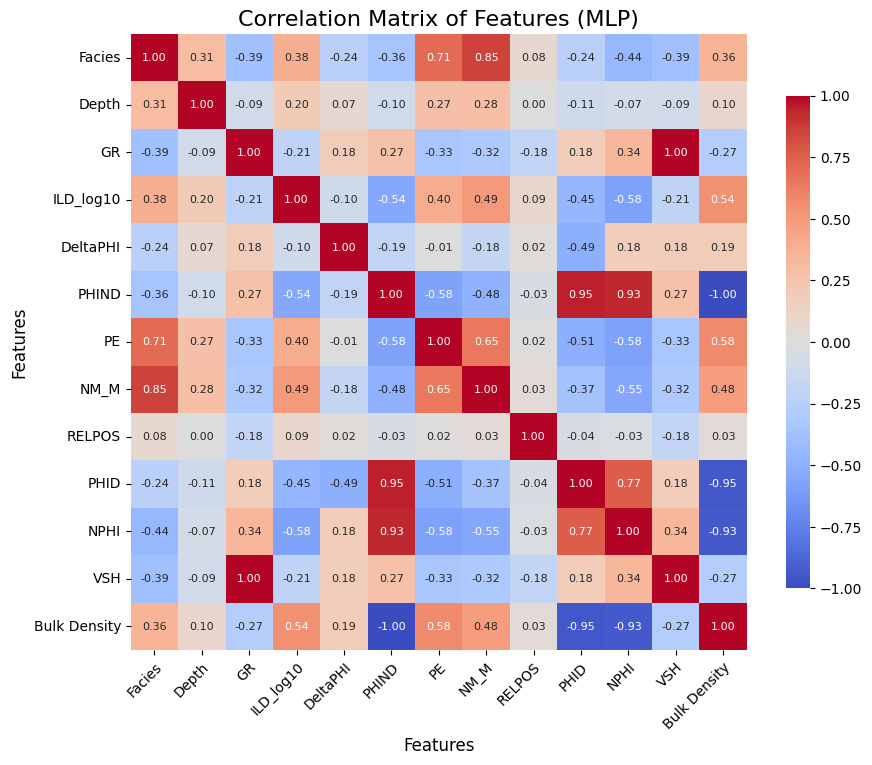

In [20]:
import seaborn as sns
corr_matrix = df.select_dtypes(include=[np.number]).corr()
print(corr_matrix)
plt.figure(figsize=(10,8))
ax=sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={"shrink": .8}, square=True, annot_kws={"size":8})
plt.title("Correlation Matrix of Features (MLP)", fontsize=16)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")
ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
ax.set_ylim(0, len(corr_matrix),0)
plt.show()
plt.savefig('../../figures/supervised/MLP_training_data_correlation_matrix.png', dpi=300, bbox_inches='tight')


##  Build and Train MLP

In [24]:
from sklearn.neural_network import MLPClassifier

mlp=MLPClassifier(hidden_layer_sizes=(20,8,10), 
                  max_iter=5000,
                  random_state=42,
                  activation="relu",
                  solver='sgd',
                  alpha=0.0001,
                  batch_size='auto',
                  learning_rate='constant',
                  verbose=True,
                  tol= 0.000000001)

mlp.fit(X_train_scaled,y_train)


Iteration 1, loss = 2.35169414
Iteration 2, loss = 2.27189816
Iteration 3, loss = 2.19315411
Iteration 4, loss = 2.12355482
Iteration 5, loss = 2.05990356
Iteration 6, loss = 2.00005131
Iteration 7, loss = 1.94326370
Iteration 8, loss = 1.89024342
Iteration 9, loss = 1.84118710
Iteration 10, loss = 1.79605361
Iteration 11, loss = 1.75686213
Iteration 12, loss = 1.72190314
Iteration 13, loss = 1.69112855
Iteration 14, loss = 1.66384195
Iteration 15, loss = 1.63928286
Iteration 16, loss = 1.61673122
Iteration 17, loss = 1.59587219
Iteration 18, loss = 1.57648151
Iteration 19, loss = 1.55851073
Iteration 20, loss = 1.54183160
Iteration 21, loss = 1.52586396
Iteration 22, loss = 1.51079826
Iteration 23, loss = 1.49644834
Iteration 24, loss = 1.48266530
Iteration 25, loss = 1.46967806
Iteration 26, loss = 1.45718592
Iteration 27, loss = 1.44535458
Iteration 28, loss = 1.43443669
Iteration 29, loss = 1.42399238
Iteration 30, loss = 1.41421543
Iteration 31, loss = 1.40462874
Iteration 32, los

,hidden_layer_sizes,"(20, ...)"
,activation,'relu'
,solver,'sgd'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,5000
,shuffle,True
,random_state,42


In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier

# Base model
mlp = MLPClassifier(max_iter=5000, random_state=42, verbose=False)

# Parameter grid
param_grid = {
    "hidden_layer_sizes": [(50,), (100,), (50,30), (100,50,25)],
    "activation": ["relu", "tanh", "logistic"],
    "solver": ["adam", "sgd"],
    "alpha": [0.0001, 0.001, 0.01],
    "learning_rate": ["constant", "adaptive"]
}

# Grid search (tries all combinations — can be slow)
grid_search = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    cv=3,                # 3-fold cross-validation
    n_jobs=-1,           # use all CPU cores
    scoring="accuracy",  # metric
    verbose=2
)

grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)


Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   4.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   4.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   4.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   4.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   9.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   4.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   4.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=cons

/home/codespace/.local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50, 25), learning_rate=constant, solver=sgd; total time= 1.9min


/home/codespace/.local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50, 25), learning_rate=constant, solver=sgd; total time= 1.9min
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=  14.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=  13.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=  10.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50, 25), learning_rate=adaptive, solver=sgd; total time= 1.4min
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  15.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  14.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  15.3s
[CV] END activation

/home/codespace/.local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50, 25), learning_rate=adaptive, solver=sgd; total time= 1.9min
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=  12.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=  10.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  15.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  14.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  15.8s


/home/codespace/.local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50, 25), learning_rate=adaptive, solver=sgd; total time= 1.9min
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=  16.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=  18.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=  15.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=  16.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=  28.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=  34.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=  18.5s
[CV] END activation

/home/codespace/.local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50, 25), learning_rate=constant, solver=sgd; total time= 1.9min


/home/codespace/.local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50, 25), learning_rate=constant, solver=sgd; total time= 1.9min
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=  11.1s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=  11.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50, 25), learning_rate=adaptive, solver=sgd; total time= 1.4min
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=  10.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  14.1s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  14.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  15.4s
[CV] END activation=tanh, a

/home/codespace/.local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50, 25), learning_rate=adaptive, solver=sgd; total time= 1.9min
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  14.2s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  14.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  15.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=  11.2s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=  16.0s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=  15.3s


/home/codespace/.local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50, 25), learning_rate=adaptive, solver=sgd; total time= 1.9min
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=  22.1s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=  16.1s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=  33.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=  11.2s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=  31.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=  15.0s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=  22.5s
[CV] END activation=tanh, alp

/home/codespace/.local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50, 25), learning_rate=constant, solver=sgd; total time= 1.9min
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=  10.3s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=  16.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50, 25), learning_rate=adaptive, solver=sgd; total time= 1.4min
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=  12.3s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  12.2s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  12.1s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time= 

/home/codespace/.local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50, 25), learning_rate=adaptive, solver=sgd; total time= 1.9min
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  12.7s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  12.4s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  11.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50, 25), learning_rate=adaptive, solver=sgd; total time= 1.8min
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=  12.7s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=  17.0s
[CV] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total tim

## Predict and Evaluate

In [42]:
facies_predicted=mlp.predict(X_test_scaled)


In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
print("Classification_Report:\n",classification_report(y_test,facies_predicted,target_names=facies_labels))

Classification_Report:
               precision    recall  f1-score   support

          SS       0.81      0.54      0.64        54
        CSiS       0.68      0.77      0.72       205
        FSiS       0.70      0.68      0.69       152
        SiSh       0.58      0.75      0.66        52
          MS       0.00      0.00      0.00        54
          WS       0.47      0.67      0.55       112
           D       0.70      0.55      0.62        29
          PS       0.63      0.59      0.61       131
          BS       0.68      0.61      0.64        41

    accuracy                           0.63       830
   macro avg       0.58      0.57      0.57       830
weighted avg       0.60      0.63      0.61       830



In [44]:
conf_mat_mlp=confusion_matrix(y_test,facies_predicted)
print("Confusion Matrix:\n",conf_mat_mlp)


Confusion Matrix:
 [[ 29  23   2   0   0   0   0   0   0]
 [  6 158  40   0   0   0   0   1   0]
 [  0  48 104   0   0   0   0   0   0]
 [  0   0   0  39   0  12   0   1   0]
 [  0   1   1   5   0  35   1  11   0]
 [  1   0   0  17   0  75   4  13   2]
 [  0   1   0   1   2   2  16   6   1]
 [  0   1   2   5   1  34   2  77   9]
 [  0   0   0   0   0   2   0  14  25]]


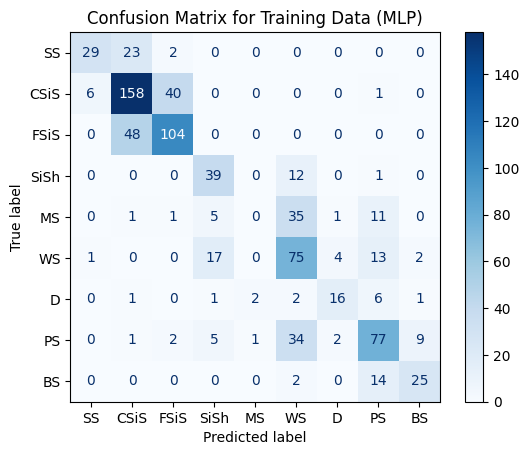

In [45]:
disp=ConfusionMatrixDisplay(confusion_matrix=conf_mat_mlp,
                            display_labels=facies_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Training Data (MLP)")
plt.savefig('../../figures/supervised/MLP_classifier_confusion_matrix.png', dpi=300)

In [57]:
def accuracy(conf_mat_mlp):
    total_correct=0
    nb_classes=conf_mat_mlp.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct=total_correct+conf_mat_mlp[i,i]
    acc=total_correct/conf_mat_mlp.sum()
    return acc

## Adjacent Facies Accuracy

In [74]:

def adjacent_accuracy(conf_mat_mlp, adjacent_facies):
    total_correct = 0
    nb_classes = conf_mat_mlp.shape[0]
    for i in range(nb_classes):
        total_correct += conf_mat_mlp[i, i]  # exact match
        for j in adjacent_facies[i]:
            total_correct += conf_mat_mlp[i, j]  # adjacent match
    adj_acc = total_correct / conf_mat_mlp.sum()
    return adj_acc


In [75]:
print("Facies classification accuracy:\n",accuracy(conf_mat_mlp))
print("Adjacent facies classification accuracy:\n",adjacent_accuracy(conf_mat_mlp, [[1], [0, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7], [6, 8], [7]]))

Facies classification accuracy:
 0.6301204819277109
Adjacent facies classification accuracy:
 0.863855421686747


In [76]:

acc = accuracy(conf_mat_mlp) * 100  

#  Adjacent Facies Accuracy
adjacent_facies = [
    [1],        # SS (1)  -> 2
    [0, 2],     # CSiS (2) -> 1,3
    [1],        # FSiS (3) -> 2
    [4],        # SiSh (4) -> 5
    [3, 5],     # MS (5)  -> 4,6
    [4, 6],     # WS (6)  -> 5,7
    [5, 7],     # D (7)   -> 6,8
    [5, 6, 8],  # PS (8)  -> 6,7,9
    [6, 7]      # BS (9)  -> 7,8
]
adj_acc = adjacent_accuracy(conf_mat_mlp, adjacent_facies) * 100  

# 🎨 Beautiful structured print
print("="*50)
print("🎯 Facies Classification Performance")
print("="*50)
print(f"👉 Standard Accuracy : {acc:.2f}%")
print(f"👉 Adjacent Accuracy : {adj_acc:.2f}%")
print("="*50)


🎯 Facies Classification Performance
👉 Standard Accuracy : 63.01%
👉 Adjacent Accuracy : 90.48%


In [77]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

In [79]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from src.classification_utilities import display_cm, display_adj_cm
conf_mat=confusion_matrix(y_test, facies_predicted)
display_cm(conf_mat, facies_labels,hide_zeros=True)


    Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BSTotal
    True
       SS   29   23    2                                 54
     CSiS    6  158   40                        1       205
     FSiS        48  104                                152
     SiSh                  39        12         1        52
       MS         1    1    5        35    1   11        54
       WS    1             17        75    4   13    2  112
        D         1         1    2    2   16    6    1   29
       PS         1    2    5    1   34    2   77    9  131
       BS                             2        14   25   41


/workspaces/Facies-classification-using-ml/src/classification_utilities.py:12: RuntimeWarning: invalid value encountered in divide
  F1 = 2 * (precision * recall) / (precision + recall)


In [84]:
display_cm(conf_mat_mlp, facies_labels,display_metrics=True,hide_zeros=True)

    Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BSTotal
    True
       SS   29   23    2                                 54
     CSiS    6  158   40                        1       205
     FSiS        48  104                                152
     SiSh                  39        12         1        52
       MS         1    1    5        35    1   11        54
       WS    1             17        75    4   13    2  112
        D         1         1    2    2   16    6    1   29
       PS         1    2    5    1   34    2   77    9  131
       BS                             2        14   25   41

Precision  0.81  0.68  0.70  0.58  0.00  0.47  0.70  0.63  0.68  0.60
   Recall  0.54  0.77  0.68  0.75  0.00  0.67  0.55  0.59  0.61  0.63
       F1  0.64  0.72  0.69  0.66  0.00  0.55  0.62  0.61  0.64  0.61


In [82]:
display_adj_cm(conf_mat_mlp, facies_labels, adjacent_facies, display_metrics=True, hide_zeros=True)

    Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BSTotal
    True
       SS   52         2                                 54
     CSiS       204                             1       205
     FSiS            152                                152
     SiSh                  39        12         1        52
       MS         1    1        40         1   11        54
       WS    1             17        79        13    2  112
        D         1         1    2        24         1   29
       PS         1    2    5    1            122       131
       BS                             2             39   41

Precision  0.98  0.99  0.97  0.63  0.93  0.85  0.96  0.82  0.93  0.91
   Recall  0.96  1.00  1.00  0.75  0.74  0.71  0.83  0.93  0.95  0.90
       F1  0.97  0.99  0.98  0.68  0.82  0.77  0.89  0.87  0.94  0.90


# Applying the classification model to the blind well

In [85]:
blind_well

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,PHID,NPHI,VSH,Bulk Density,PE_filled,FaciesLabels
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000,6.965,16.865,0.191740,2.453403,Original,FSiS
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979,5.465,19.665,0.194048,2.442677,Original,FSiS
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957,5.650,20.450,0.196299,2.434675,Original,FSiS
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936,6.165,20.065,0.216384,2.433603,Original,FSiS
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915,6.550,20.050,0.183564,2.430550,Original,FSiS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,8,C LM,SHRIMPLIN,3026.0,17.92,0.808,1.5,9.730,5.4,2,0.049,8.980,10.480,0.022140,2.489455,Original,PS
467,8,C LM,SHRIMPLIN,3026.5,16.51,0.814,2.0,8.275,5.5,2,0.039,7.275,9.275,0.018122,2.513463,Original,PS
468,8,C LM,SHRIMPLIN,3027.0,21.94,0.820,3.3,7.680,5.4,2,0.029,6.030,9.330,0.033592,2.523280,Original,PS
469,8,C LM,SHRIMPLIN,3027.5,32.54,0.821,2.5,7.445,5.8,2,0.020,6.195,8.695,0.063792,2.527157,Original,PS


In [91]:
facies_blind=blind_well["Facies"].values
facies_blind

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 8,
       8, 8, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 4, 4, 4, 4,
       4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
       5, 5, 5, 5, 8, 8, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6, 6, 6, 3, 3, 3, 3,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 6, 6, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 3, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 8, 8, 8, 8, 8, 8, 8, 6, 6, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8,

In [101]:
blind_features=blind_well.drop(columns=['Well Name', 'Formation', 'Depth', 'Facies', 'FaciesLabels',"PE_filled"])
blind_features.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,PHID,NPHI,VSH,Bulk Density
count,471.000000,471.000000,471.000000,471.000000,471.000000,471.000000,471.000000,471.000000,471.000000,471.000000,471.000000
mean,69.408896,0.659679,7.708493,12.173705,4.219958,1.488323,0.514482,8.319459,16.027951,0.168831,2.449134
std,37.299536,0.232894,4.279453,5.317152,0.902823,0.500395,0.289757,4.804196,6.528459,0.106266,0.087733
min,13.280000,0.297000,-4.300000,1.590000,2.700000,1.000000,0.010000,-1.010000,4.105000,0.008920,2.031745
25%,46.895000,0.486000,4.300000,8.065000,3.400000,1.000000,0.261000,5.207500,10.432500,0.104689,2.400396
50%,69.480000,0.580000,7.300000,12.170000,4.000000,1.000000,0.513000,7.765000,16.235000,0.169034,2.449195
75%,85.995000,0.827500,11.150000,15.127500,5.000000,2.000000,0.765000,10.407500,20.380000,0.216085,2.516927
max,361.150000,1.480000,18.500000,37.470000,6.300000,2.000000,1.000000,38.470000,36.470000,1.000000,2.623765


In [104]:
X_blind=scaler.transform(blind_features)
predicted_blind=mlp.predict(X_blind)
predicted_blind


array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 4, 6, 6,
       8, 8, 8, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 8, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 2, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 3, 3, 2, 2, 3, 3,
       3, 7, 6, 6, 6, 6, 6, 6, 6, 8, 8, 6, 6, 6, 6, 6, 6, 6, 3, 3, 3, 3,
       2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 7, 6, 8, 8, 8, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6, 8, 3, 3, 3, 2,
       3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 3, 2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 3, 3, 3, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 7, 8, 9, 8, 8, 8, 8, 6, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2,
       3, 3, 3, 3, 8, 7, 7, 8, 8, 9, 9, 9, 8, 8, 8,

### Put these predicted facies in data col

In [105]:
blind_well["Predicted_Facies"]=predicted_blind
blind_well

/tmp/ipykernel_2248/843993354.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blind_well["Predicted_Facies"]=predicted_blind


,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,PHID,NPHI,VSH,Bulk Density,PE_filled,FaciesLabels,Predicted_Facies
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000,6.965,16.865,0.191740,2.453403,Original,FSiS,3
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979,5.465,19.665,0.194048,2.442677,Original,FSiS,3
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957,5.650,20.450,0.196299,2.434675,Original,FSiS,3
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936,6.165,20.065,0.216384,2.433603,Original,FSiS,3
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915,6.550,20.050,0.183564,2.430550,Original,FSiS,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,8,C LM,SHRIMPLIN,3026.0,17.92,0.808,1.5,9.730,5.4,2,0.049,8.980,10.480,0.022140,2.489455,Original,PS,8
467,8,C LM,SHRIMPLIN,3026.5,16.51,0.814,2.0,8.275,5.5,2,0.039,7.275,9.275,0.018122,2.513463,Original,PS,8
468,8,C LM,SHRIMPLIN,3027.0,21.94,0.820,3.3,7.680,5.4,2,0.029,6.030,9.330,0.033592,2.523280,Original,PS,8
469,8,C LM,SHRIMPLIN,3027.5,32.54,0.821,2.5,7.445,5.8,2,0.020,6.195,8.695,0.063792,2.527157,Original,PS,8


### Confusion matrix of the blind well

In [108]:
conf_mat_blind=confusion_matrix(facies_blind,predicted_blind)

print("Blind well facies classification accuracy:\n",accuracy(conf_mat_blind))
print("Blind well Adjacent facies classification accuracy:\n",adjacent_accuracy(conf_mat_blind, [[1], [0, 2], [1, 3], [2,4], [3, 5], [4, 6], [5, 7], [6, 8], [7]]))


Blind well facies classification accuracy:
 0.6157112526539278
Blind well Adjacent facies classification accuracy:
 0.8768577494692145


/workspaces/Facies-classification-using-ml/src/classification_utilities.py:10: RuntimeWarning: invalid value encountered in divide
  precision = np.diagonal(cm)/cm.sum(axis=0).astype('float')
/workspaces/Facies-classification-using-ml/src/classification_utilities.py:11: RuntimeWarning: invalid value encountered in divide
  recall = np.diagonal(cm)/cm.sum(axis=1).astype('float')


    Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BSTotal
    True
       SS                                                 0
     CSiS       118                                     118
     FSiS            123                                123
     SiSh                  11         3         4        18
       MS              1        51         1   10        63
       WS                            42        20    1   63
        D                        2         3              5
       PS                        3             66        69
       BS                                           12   12

Precision  0.00  1.00  0.99  1.00  0.91  0.93  0.75  0.66  0.92  0.92
   Recall  0.00  1.00  1.00  0.61  0.81  0.67  0.60  0.96  1.00  0.90
       F1  0.00  1.00  1.00  0.76  0.86  0.78  0.67  0.78  0.96  0.90


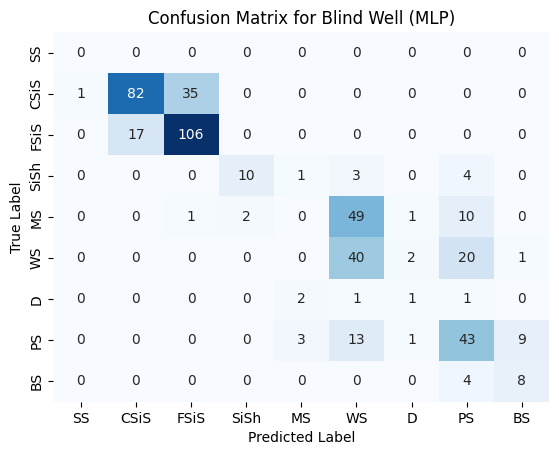

In [119]:
display_adj_cm(conf_mat_blind, facies_labels, adjacent_facies, 
           display_metrics=True, hide_zeros=True)

sns.heatmap(conf_mat_blind, annot=True, fmt="d", cmap='Blues', cbar=False,
            xticklabels=facies_labels, yticklabels=facies_labels)
plt.title("Confusion Matrix for Blind Well (MLP)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig('../../figures/supervised/MLP_blind_well_confusion_matrix.png', dpi=300, bbox_inches='tight')

In [110]:
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)
    return f, ax

In [113]:
blind_well.columns

Index(['Facies', 'Formation', 'Well Name', 'Depth', 'GR', 'ILD_log10',
       'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS', 'PHID', 'NPHI', 'VSH',
       'Bulk Density', 'PE_filled', 'FaciesLabels', 'Predicted_Facies'],
      dtype='object')

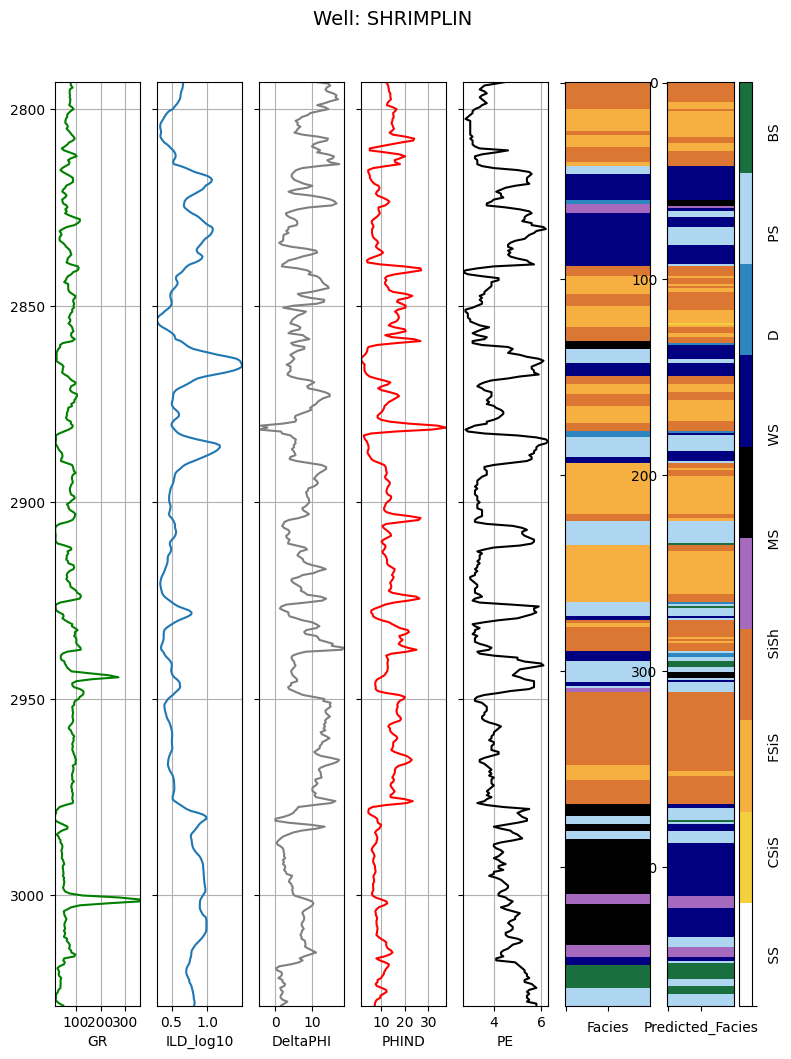

In [114]:
compare_facies_plot(blind_well, 'Predicted_Facies', facies_colors)
plt.savefig('../../figures/supervised/MLP_blind_well_facies_comparison.png', dpi=300)

### Push Code to GitHub

```bash
# Check the current status of your repo
git status

# Add all modified files
git add .

# Commit with a message
git commit -m "Updated MLP classifier notebook with confusion matrix and accuracy metrics"

# Push changes to the main branch
git push origin main
